### 26-Jan-2020

In [15]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [16]:
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(16, 4)})
plt.rc('figure',figsize=(16,4))
plt.rc('font',size=13)

import warnings
warnings.filterwarnings("ignore")

## Data Preparation

In [17]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train_original = train.copy()
test_original = test.copy()

In [114]:
train.shape, test.shape

((649912, 15), (284071, 9))

In [115]:
train.columns

Index(['id', 'epoch', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim',
       'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [116]:
test.columns

Index(['id', 'sat_id', 'epoch', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim'],
      dtype='object')

In [117]:
train.dtypes

id          int64
epoch      object
sat_id      int64
x         float64
y         float64
z         float64
Vx        float64
Vy        float64
Vz        float64
x_sim     float64
y_sim     float64
z_sim     float64
Vx_sim    float64
Vy_sim    float64
Vz_sim    float64
dtype: object

In [118]:
test.dtypes

id          int64
sat_id      int64
epoch      object
x_sim     float64
y_sim     float64
z_sim     float64
Vx_sim    float64
Vy_sim    float64
Vz_sim    float64
dtype: object

In [12]:
# change epoch to datetime and id, sat_id to unsigned integers
train['epoch'] = pd.to_datetime(train['epoch'], infer_datetime_format=True)
test['epoch'] = pd.to_datetime(test['epoch'], infer_datetime_format=True)

train['id'] = pd.to_numeric(train['id'], downcast='unsigned')
test['id'] = pd.to_numeric(test['id'], downcast='unsigned')

train['sat_id'] = pd.to_numeric(train['sat_id'], downcast='unsigned')
test['sat_id'] = pd.to_numeric(test['sat_id'], downcast='unsigned')

In [120]:
# set indices to epoch
#train = train.set_index('epoch')
#test = test.set_index('epoch')

In [7]:
# alternative method of setting indices without dropping epoch
train.index = train['epoch']
test.index = test['epoch']

In [11]:
#train = train_original.copy()
#test = test_original.copy()

In [14]:
train.to_pickle('train.pkl')
test.to_pickle('test.pkl')

In [129]:
# select the 300 satellites from train that are in test
sat_ids = test['sat_id'].unique()

In [132]:
# for the satellite number of each observation in train, is it also in the array of unique satellite numbers in test?
boolean = [sat_no in sat_ids for sat_no in train['sat_id']]

In [135]:
train_300 = train[boolean]

In [141]:
# check if 300 satellites in train exactly match the 300 satellites in test
sum(train_300['sat_id'].unique() != test['sat_id'].unique())

0

In [160]:
# make another dataset for the remaining 300 satellites
booleanB = [sat_no not in sat_ids for sat_no in train['sat_id']]

In [162]:
train_300B = train[booleanB]

In [163]:
# save the prepared datasets for future use
train_300.to_csv('clean_train_300.csv')
train_300B.to_csv('clean_train_300B.csv')
test.to_csv('clean_test.csv')

In [167]:
train_300.to_pickle('clean_train_300.pkl')
train_300B.to_pickle('clean_train_300B.pkl')
test.to_pickle('clean_test.pkl')

In [171]:
del train, test, train_original, test_original, train_300, train_300B

### Start here

In [175]:
# load pickle files
train = pd.read_pickle('clean_train_300.pkl')
test = pd.read_pickle('clean_test.pkl')

In [176]:
# make a copy
train_original = train.copy()
test_original = test.copy()

In [178]:
train.columns

Index(['id', 'sat_id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz', 'x_sim', 'y_sim',
       'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim'],
      dtype='object')

In [179]:
test.columns

Index(['id', 'sat_id', 'x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim',
       'Vz_sim'],
      dtype='object')

In [180]:
# remove simulated kinematic states
train.drop(train.columns[8:], axis=1, inplace=True)
test.drop(test.columns[2:], axis=1, inplace=True)

In [187]:
train.shape, test.shape

((315183, 8), (284071, 2))

In [183]:
train.head()

,id,sat_id,x,y,z,Vx,Vy,Vz
epoch,,,,,,,,
2014-01-01 00:00:00.000,1819,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599
2014-01-01 00:21:11.845,1820,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872
2014-01-01 00:42:23.690,1821,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441
2014-01-01 01:03:35.534,1822,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151
2014-01-01 01:24:47.379,1823,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512


In [184]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 315183 entries, 2014-01-01 00:00:00 to 2014-01-31 22:38:39.653000
Data columns (total 8 columns):
id        315183 non-null uint32
sat_id    315183 non-null uint16
x         315183 non-null float64
y         315183 non-null float64
z         315183 non-null float64
Vx        315183 non-null float64
Vy        315183 non-null float64
Vz        315183 non-null float64
dtypes: float64(6), uint16(1), uint32(1)
memory usage: 18.6 MB


In [185]:
test.head()

,id,sat_id
epoch,,
2014-02-01 00:01:45.162,3927,1
2014-02-01 00:22:57.007,3928,1
2014-02-01 00:44:08.852,3929,1
2014-02-01 01:05:20.697,3930,1
2014-02-01 01:26:32.542,3931,1


In [186]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 284071 entries, 2014-02-01 00:01:45.162000 to 2014-02-28 13:30:01.658000
Data columns (total 2 columns):
id        284071 non-null uint32
sat_id    284071 non-null uint16
dtypes: uint16(1), uint32(1)
memory usage: 3.8 MB


In [210]:
# index of first observation of satellite e.g. Sat_1 is 0, Sat_2 is 2108
first_indices_train = list()  
for sat_no in train['sat_id'].unique():
    first_id = train['sat_id'].searchsorted(sat_no)
    first_indices_train.append(first_id[0])

In [195]:
first_indices_test = list()
for sat_no in test['sat_id'].unique():
    first_id = test['sat_id'].searchsorted(sat_no)
    first_indices_test.append(first_id[0])

In [226]:
# assign satellite numbers to their corresponding start locations in the main dataframes
train_ids = pd.DataFrame({'sat_id': train['sat_id'].unique(), 'start_location': first_indices_train})
test_ids = pd.DataFrame({'sat_id': test['sat_id'].unique(), 'start_location': first_indices_test})

In [224]:
train_ids.head()

,sat_id,start_location
0,1,0
1,2,2108
2,3,2525
3,4,2879
4,6,4089


In [373]:
# for example, sat515 and sat516 start at 283856 and 283967
# how can i do this with less code?
a,b = (train_ids[train_ids['sat_id'] == 515]['start_location'].iloc[0], 
       train_ids[train_ids['sat_id'] == 516]['start_location'].iloc[0])
c,d = (test_ids[test_ids['sat_id'] == 515]['start_location'].iloc[0], 
       test_ids[test_ids['sat_id'] == 516]['start_location'].iloc[0])

In [374]:
a,b,c,d

(283856, 283967, 255862, 255962)

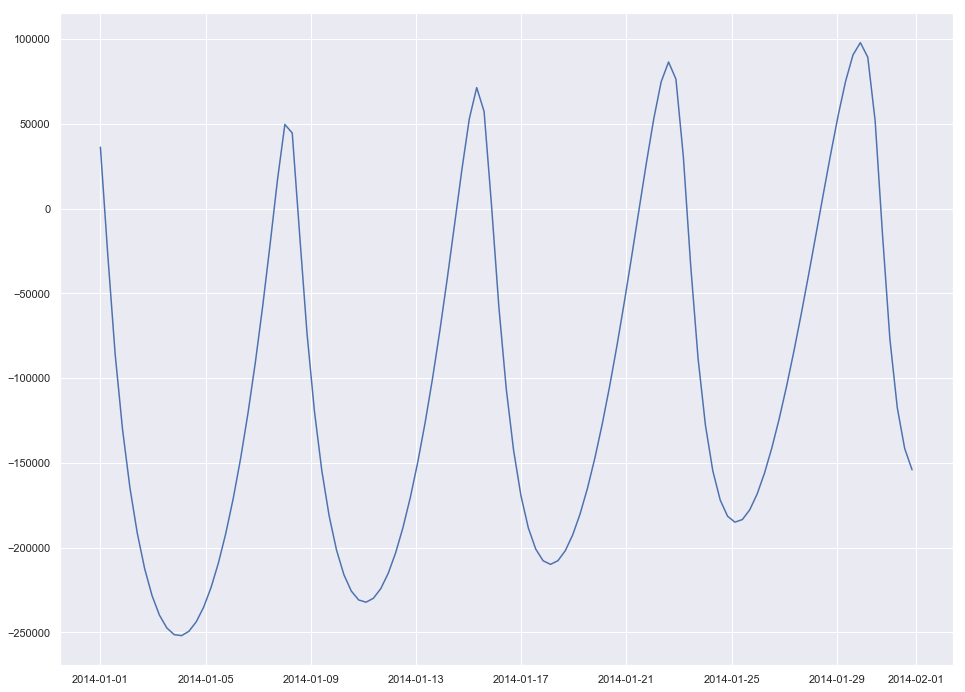

In [274]:
# i want to get data for sat515
plt.plot(train.iloc[a:b,:]['x'])

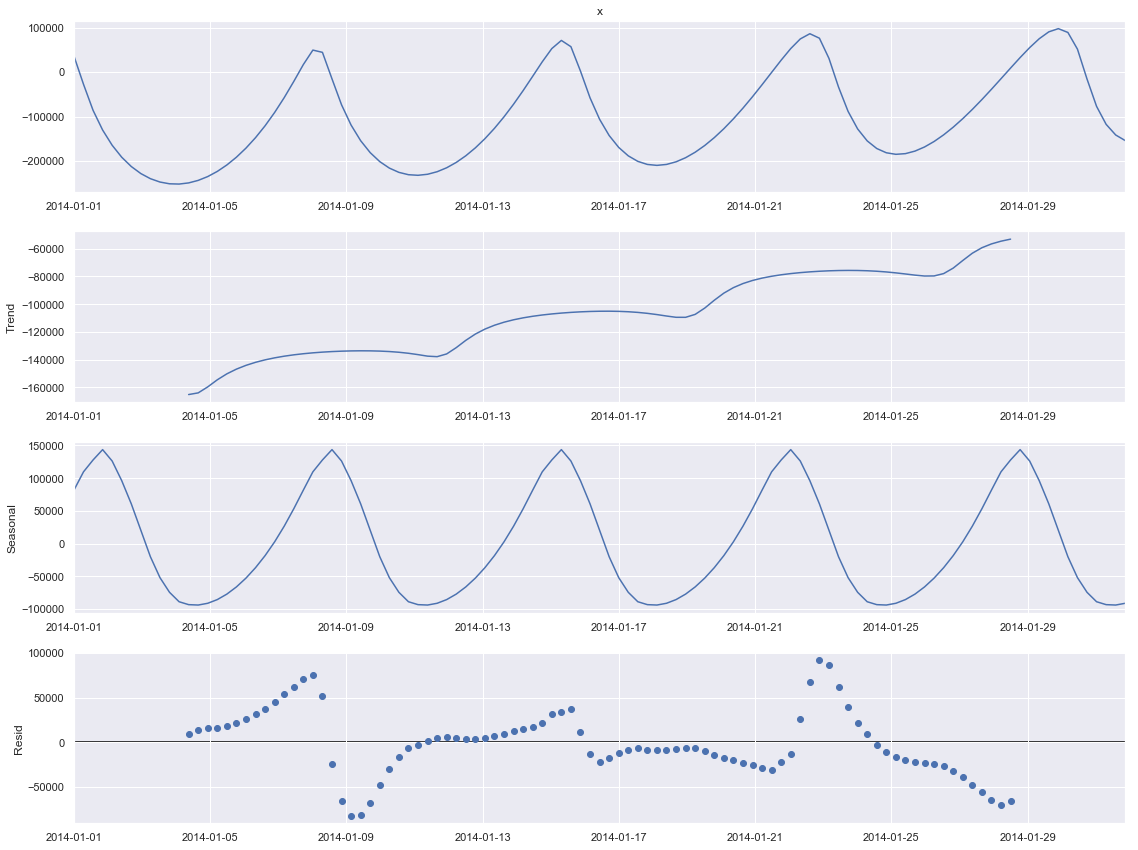

In [282]:
result = seasonal_decompose(train.iloc[a:b,:]['x'], model='additive', period=24)
result.plot()
plt.show()

In [283]:
train.head()

,id,sat_id,x,y,z,Vx,Vy,Vz
epoch,,,,,,,,
2014-01-01 00:00:00.000,1819,1,10390.313089,-2796.458271,3179.562085,2.520477,6.149930,-2.827599
2014-01-01 00:21:11.845,1820,1,11195.606833,5078.653968,-839.076593,-1.126667,5.826412,-3.255872
2014-01-01 00:42:23.690,1821,1,8235.556436,11445.904263,-4680.514023,-3.230227,4.126433,-2.704441
2014-01-01 01:03:35.534,1822,1,3560.149776,15634.195146,-7654.177182,-3.964696,2.520867,-1.978151
2014-01-01 01:24:47.379,1823,1,-1580.476891,18023.318335,-9755.287599,-4.050865,1.296388,-1.346512


In [291]:
# calculate offsets based on max - min for each kinematic state and shift them by that amount
offsets = list()
for k in range(2,8):
    offsets.append(max(train.iloc[:,k]) - min(train.iloc[:,k])) 

In [292]:
offsets

[452321.4565359045,
 497868.7205273191,
 349633.1868044764,
 16.09022879622238,
 14.526208272799238,
 17.11475026730063]

In [328]:
#offsets = list()
cols = train.columns
for k in range(2,8):
    train[cols[k]] = train[cols[k]] + offsets[k-2] #(max(train.iloc[:,k]) - min(train.iloc[:,k]))

In [330]:
train.head()

,id,sat_id,x,y,z,Vx,Vy,Vz
epoch,,,,,,,,
2014-01-01 00:00:00.000,1819,1,462711.769625,495072.262257,352812.748890,18.610706,20.676139,14.287152
2014-01-01 00:21:11.845,1820,1,463517.063369,502947.374495,348794.110212,14.963562,20.352621,13.858878
2014-01-01 00:42:23.690,1821,1,460557.012972,509314.624790,344952.672781,12.860001,18.652641,14.410310
2014-01-01 01:03:35.534,1822,1,455881.606312,513502.915674,341979.009622,12.125533,17.047076,15.136599
2014-01-01 01:24:47.379,1823,1,450740.979645,515892.038862,339877.899206,12.039364,15.822596,15.768239


In [314]:
# check that all data are strictly positive
# any() returns False iff all elements are False
(train <= 0).any()

id        False
sat_id    False
x         False
y         False
z         False
Vx        False
Vy        False
Vz        False
dtype: bool

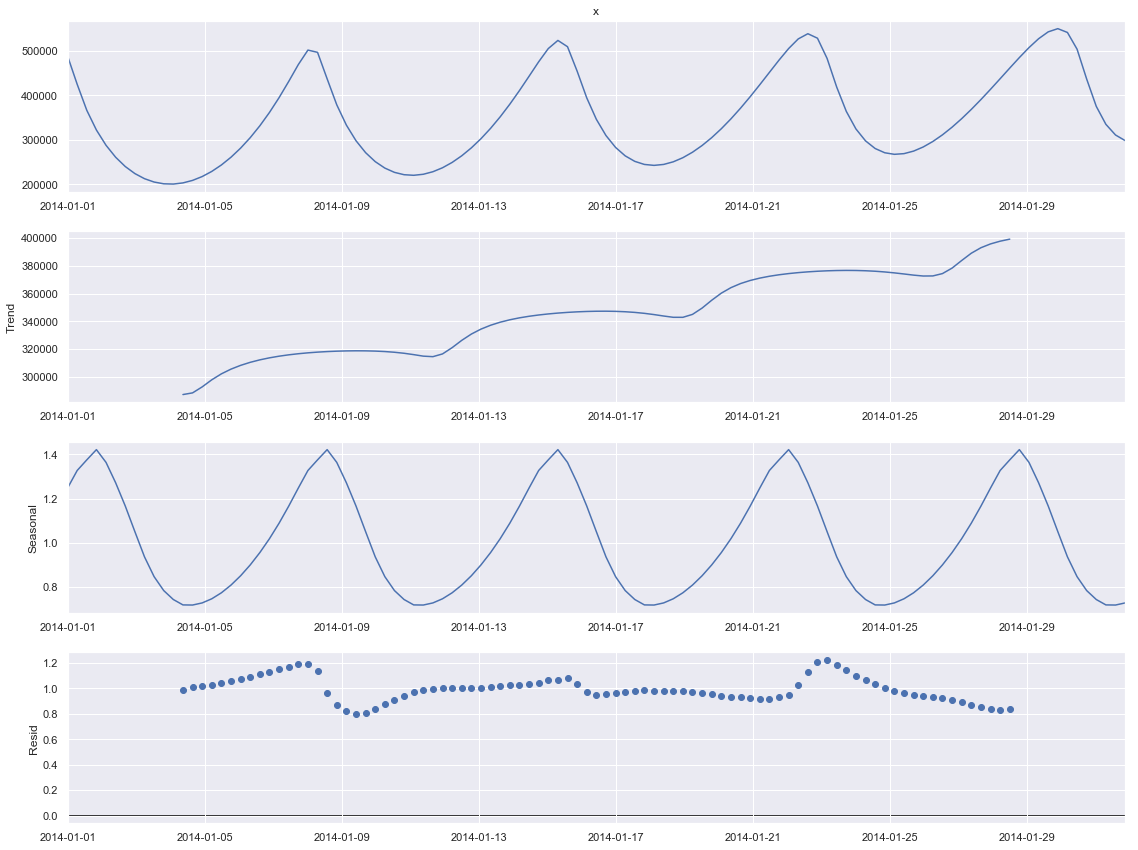

In [322]:
result = seasonal_decompose(train.iloc[a:b,:]['x'], model='multiplicative', period=24)
result.plot()
plt.show()

In [378]:
testt = test.copy()

In [387]:
testt['x'] = np.nan

In [388]:
testt.head()

,id,sat_id,x
epoch,,,
2014-02-01 00:01:45.162,3927,1,NaN
2014-02-01 00:22:57.007,3928,1,NaN
2014-02-01 00:44:08.852,3929,1,NaN
2014-02-01 01:05:20.697,3930,1,NaN
2014-02-01 01:26:32.542,3931,1,NaN


In [379]:
fit = ExponentialSmoothing(np.asarray(train.iloc[a:b,:]['x']),
                           trend=None, seasonal='add', seasonal_periods=24, damped=False).fit()

In [ ]:
# forecast into arrays first, then combine them and put them into Test
fc = fit.forecast(d-c)

In [394]:
len(testt.iloc[c:d,:])

100

In [395]:
len(fit.forecast(d-c))

100

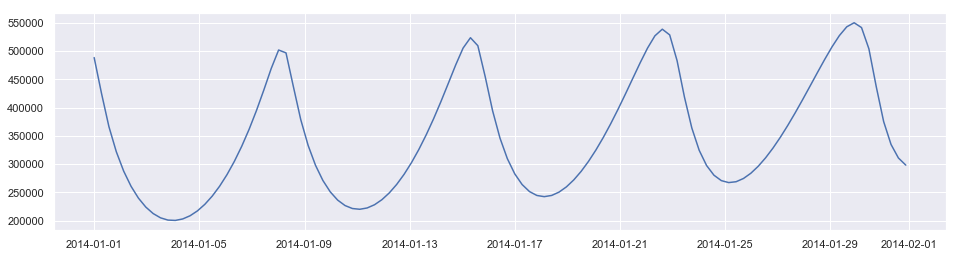

In [355]:
plt.plot(train.iloc[a:b,:]['x'])


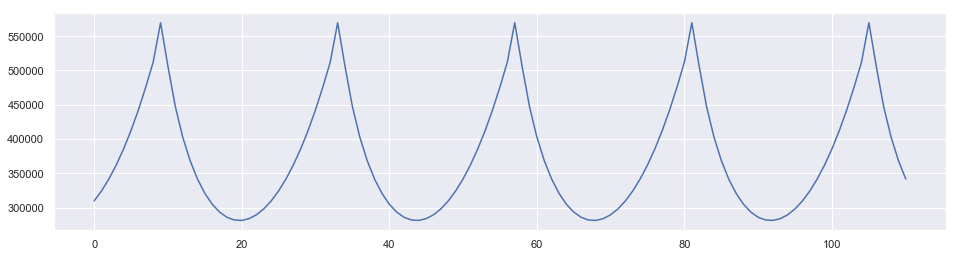

In [372]:
plt.plot(c)